In [1]:
%run setup.ipynb

In [2]:
output_dir = Path('/home/joshjrey/Documents/mosquito_project/outputs/build_blocks')

In [3]:
seq_cls = zarr.open_group(str(output_dir / 'seq_cls.zarr.zip'))
codon_position = zarr.open_group(str(output_dir / 'codon_position.zarr.zip'))
codon_degeneracy = zarr.open_group(str(output_dir / 'codon_degeneracy.zarr.zip'))
allele_counts = phase2_ar1.allele_counts
callset = phase2_ar1.callset
accessibility = phase2_ar1.accessibility

In [4]:
test_callset = zarr.open_group('/home/joshjrey/Documents/mosquito_project/data/ag1k/phase2.AR1/variation/main/zarr2/ag1000g.phase2.ar1', mode = 'r')

In [5]:
test_callset['3L'].tree()
test_callset.tree()

/
 ├── 2L
 │   ├── calldata
 │   │   ├── AD (8906423, 1142, 4) uint16
 │   │   ├── GQ (8906423, 1142) uint8
 │   │   └── genotype (8906423, 1142, 2) int8
 │   └── variants
 │       ├── ALT (21442865, 3) |S1
 │       ├── FILTER_PASS (21442865,) bool
 │       ├── POS (21442865,) int32
 │       └── REF (21442865,) |S1
 ├── 2R
 │   └── variants
 │       ├── ALT (24767689, 3) |S1
 │       ├── FILTER_PASS (24767689,) bool
 │       ├── POS (24767689,) int32
 │       └── REF (24767689,) |S1
 ├── 3L
 │   ├── calldata
 │   │   └── genotype (18167056, 1142, 2) int8
 │   └── variants
 │       ├── ALT (18167056, 3) |S1
 │       ├── FILTER_PASS (18167056,) bool
 │       ├── POS (18167056,) int32
 │       └── REF (18167056,) |S1
 ├── 3R
 │   └── variants
 │       ├── ALT (24943504, 3) |S1
 │       ├── FILTER_PASS (24943504,) bool
 │       ├── POS (24943504,) int32
 │       └── REF (24943504,) |S1
 ├── UNKN
 │   └── variants
 │       ├── ALT (6759497, 3) |S1
 │       ├── FILTER_PASS (6759497,) bool
 │       ├── POS (6759497,) int32
 │       └── REF (6759497,) |S1
 ├── X
 │   └── variants
 │       ├── ALT (9389639, 3) |S1
 │       ├── FILTER_PASS (9389639,) bool
 │       ├── POS (9389639,) int32
 │       └── REF (9389639,) |S1
 ├── Y_unplaced
 │   └── variants
 │       ├── ALT (16448, 3) |S1
 │       ├── FILTER_PASS (16448,) bool
 │       ├── POS (16448,) int32
 │       └── REF (16448,) |S1
 └── samples (1142,) |S8

In [6]:
DEG_UNKNOWN = 0
DEG_0 = 1
DEG_2_SIMPLE = 2
DEG_2_COMPLEX = 3
DEG_4 = 4

In [7]:
genome = phase2_ar1.genome_agamp3
genome

## Access outgroup data

In [8]:
@functools.lru_cache(maxsize=None)
def load_outgroup_alleles(seqid, species):

    if species in {'chri', 'epir'}:
        variants_fn = (
            '/home/joshjrey/projects/mos-proj/phase1.AR3/agc/%s_fake_cnvrt_sort.vcf.gz.vcfnp_cache/variants.%s.npy'
            % (species, seqid)
        )
        variants = np.load(variants_fn)
        pos = variants['POS']
        ref = variants['REF']
        alt = variants['ALT']
        
        outgroup_allele = np.where(alt == b'.', ref, alt)
        
    else:

        callset_fn = (
            '/home/joshjrey/projects/mos-proj/phase1.AR3/agc/UnifiedGenotyper/%s_ref_ug_vqsr_cnvrt_sort.h5'
            % species
        )
        callset = h5py.File(callset_fn, mode='r')
        
        # compute allele counts
        g = allel.GenotypeDaskArray(callset[seqid]['calldata/genotype'])
        ac = g.count_alleles(max_allele=1).compute()
        an = ac.sum(axis=1).max()

        # obtain helper arrays
        variants = callset[seqid]['variants']
        pos = variants['POS'][:]
        ref = variants['REF'][:]
        alt = variants['ALT'][:]
        
        # don't call allele unless it's fixed
        outgroup_allele = np.empty_like(ref)
        outgroup_allele[:] = b'N'
        loc_ref = ac[:, 0] == an
        loc_alt = ac[:, 1] == an
        outgroup_allele[loc_ref] = ref[loc_ref]
        outgroup_allele[loc_alt] = alt[loc_alt]
        
    # fill out to length of chromosome
    out = np.empty(len(genome[seqid]), dtype='S1')
    out[:] = b'N'
    out[pos - 1] = outgroup_allele
    return out



In [9]:
callset['3L']['variants']

<zarr.hierarchy.Group '/3L/variants' read-only>

In [10]:
oa = load_outgroup_alleles('3L', 'meru')

In [11]:
# arab mela meru quad epir chri
oa = load_outgroup_alleles('3L', 'epir')

In [12]:
oa

array([b'N', b'N', b'N', ..., b'N', b'N', b'N'], dtype='|S1')

In [13]:
oa.shape

(41963435,)

In [14]:
for i, v in enumerate(np.bincount(oa.view('u1'))):
    if v > 0:
        print(chr(i), v)

A 6015683
C 5063275
G 5055585
N 19826073
T 6002819


In [15]:
oa = load_outgroup_alleles('3L', 'chri')

In [16]:
for i, v in enumerate(np.bincount(oa.view('u1'))):
    if v > 0:
        print(chr(i), v)

A 6152587
C 4740784
G 4735766
N 20191307
T 6142991


## Compute number of accessible sites

In [17]:
def compute_accessible_sites(seqid):
    seq_deg = codon_degeneracy[seqid][:]
    is_accessible = accessibility[seqid]['is_accessible'][:]
    for deg, lbl in zip([DEG_0, DEG_2_SIMPLE, DEG_2_COMPLEX, DEG_4],
                        ['0-fold', '2-fold simple', '2-fold complex', '4-fold']):
        loc = is_accessible & (seq_deg == deg)
        print(seqid, lbl, np.count_nonzero(loc))


In [18]:
compute_accessible_sites('3R')
compute_accessible_sites('3L')

3R 0-fold 2279670
3R 2-fold simple 515175
3R 2-fold complex 404277
3R 4-fold 628995
3L 0-fold 1659718
3L 2-fold simple 373812
3L 2-fold complex 298608
3L 4-fold 458806


## Compute allele counts tables

Output, table with columns:
* POS
* REF
* ALT
* MERUS
* MELAS
* CHRISTYI
* CODON_POS
* CODON_DEG
* REF_AC
* ALT_AC


In [19]:
allel.AlleleCountsArray(allele_counts['3L']['BFgam'])

<AlleleCountsArray shape=(18167056, 4) dtype=uint32>
0 2 0 0
0 2 0 0
0 2 0 0
...
136   0   0   0
 46   0   0   0
 18   0   0   0

In [20]:
def build_df(pop, seqid):

    variants = callset[seqid]['variants']
    pos = variants['POS'][:]
    ref = variants['REF'][:]
    alt = variants['ALT'][:]
    filter_pass = variants['FILTER_PASS'][:]
    ac = allel.AlleleCountsArray(allele_counts[seqid][pop])
    snp_cod_deg = codon_degeneracy[seqid].get_coordinate_selection(pos - 1)
    snp_cod_pos = codon_position[seqid].get_coordinate_selection(pos - 1)
    loc_base = (
        filter_pass & 
        ac.is_biallelic_01() & 
        (snp_cod_deg >= 0) & 
        (snp_cod_deg != DEG_UNKNOWN)
    )
    pos_base = pos[loc_base]
    
    df = pandas.DataFrame.from_items([
        ('POS', pos_base),
        ('REF', ref[loc_base].astype('U')),
        ('ALT', alt[loc_base][:, 0].astype('U')),
        ('EPIR', load_outgroup_alleles(seqid, 'epir').take(pos_base - 1).astype('U')),
        ('CHRI', load_outgroup_alleles(seqid, 'chri').take(pos_base - 1).astype('U')),
        ('MERU', load_outgroup_alleles(seqid, 'meru').take(pos_base - 1).astype('U')),
        ('MELA', load_outgroup_alleles(seqid, 'mela').take(pos_base - 1).astype('U')),
        ('QUAD', load_outgroup_alleles(seqid, 'quad').take(pos_base - 1).astype('U')),
        ('ARAB', load_outgroup_alleles(seqid, 'arab').take(pos_base - 1).astype('U')),
        ('CODON_POS', snp_cod_pos[loc_base]),
        ('CODON_DEG', snp_cod_deg[loc_base]),
        ('REF_AC', ac[loc_base][:, 0]),
        ('ALT_AC', ac[loc_base][:, 1]),
    ])
    
    return df

In [21]:
callset['3L']['variants']

<zarr.hierarchy.Group '/3L/variants' read-only>

In [22]:
df = build_df('BFgam', '3L')
df.head()

/home/joshjrey/.local/lib/python3.6/site-packages/ipykernel_launcher.py:32: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.


,POS,REF,ALT,EPIR,CHRI,MERU,MELA,QUAD,ARAB,CODON_POS,CODON_DEG,REF_AC,ALT_AC
0,66681,G,A,A,A,G,G,G,G,2,2,182,2
1,80832,A,G,A,A,A,A,A,A,2,2,183,1
2,81082,G,A,A,A,A,A,A,A,2,2,9,175
3,81267,A,G,T,C,A,A,A,A,2,4,183,1
4,81759,G,A,A,A,G,G,G,G,2,4,180,4


In [23]:
df.tail()

,POS,REF,ALT,EPIR,CHRI,MERU,MELA,QUAD,ARAB,CODON_POS,CODON_DEG,REF_AC,ALT_AC
240042,41952096,A,G,A,A,A,A,A,A,2,4,183,1
240043,41952156,T,C,T,C,C,C,C,C,2,2,180,4
240044,41953559,A,G,G,G,A,A,A,A,0,1,183,1
240045,41953560,C,T,C,C,C,C,C,C,1,1,183,1
240046,41953567,T,C,A,G,T,T,T,T,2,2,181,3


In [25]:
seqid = '3L'
for pop in 'BFgam', 'BFcol', 'KE':
    #for seqid in '3R', '3L':
    log(pop, seqid)
    df = build_df(pop, seqid)
    df.to_csv(output_dir / '{pop}.{seqid}.csv'.format(pop=pop, seqid=seqid), 
                  index=False)

BFgam 3L


/home/joshjrey/.local/lib/python3.6/site-packages/ipykernel_launcher.py:32: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.


BFcol 3L


/home/joshjrey/.local/lib/python3.6/site-packages/ipykernel_launcher.py:32: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.


KE 3L


In [26]:
!ls -lh {output_dir}

total 73M
-rw-r--r-- 1 joshjrey joshjrey 6.9M May 21 11:33 BFcol.3L.csv
-rw-r--r-- 1 joshjrey joshjrey 8.1M May 21 11:33 BFgam.3L.csv
-rw-r--r-- 1 joshjrey joshjrey  11M May  3 16:45 codon_degeneracy.zarr.zip
-rw-r--r-- 1 joshjrey joshjrey 9.9M May  3 16:45 codon_nonsyn.zarr.zip
-rw-r--r-- 1 joshjrey joshjrey 1.8M May  3 16:45 codon_position.zarr.zip
-rw-r--r-- 1 joshjrey joshjrey 1.5M May 21 11:33 KE.3L.csv
-rw-r--r-- 1 joshjrey joshjrey 1.8M May  7 15:42 seq_cls.zarr.zip
-rw-r--r-- 1 joshjrey joshjrey 5.4M May  7 15:44 seq_flen.zarr.zip
-rw-r--r-- 1 joshjrey joshjrey  12M May  7 15:44 seq_relpos_start.zarr.zip
-rw-r--r-- 1 joshjrey joshjrey  12M May  7 15:44 seq_relpos_stop.zarr.zip
-rw-r--r-- 1 joshjrey joshjrey 2.3M May  3 16:12 tbl_features.pkl.gz
-rw-r--r-- 1 joshjrey joshjrey 2.2M May  3 16:12 tbl_features.txt.gz


## Check

In [27]:
df = pandas.read_csv(output_dir / 'BFcol.3L.csv')
df.head()

,POS,REF,ALT,EPIR,CHRI,MERU,MELA,QUAD,ARAB,CODON_POS,CODON_DEG,REF_AC,ALT_AC
0,66672,G,T,G,G,G,G,G,G,2,2,149,1
1,80944,G,A,A,G,G,G,G,G,2,4,149,1
2,80946,G,T,G,G,G,G,G,G,0,1,149,1
3,81058,G,A,T,G,G,G,G,G,2,4,149,1
4,81237,C,T,T,C,C,C,C,C,2,2,149,1


In [28]:
# check
ac = np.column_stack([df['REF_AC'], df['ALT_AC']])
ac

array([[149,   1],
       [149,   1],
       [149,   1],
       ...,
       [148,   2],
       [148,   2],
       [149,   1]])

In [29]:
%matplotlib notebook

<IPython.core.display.Javascript object>


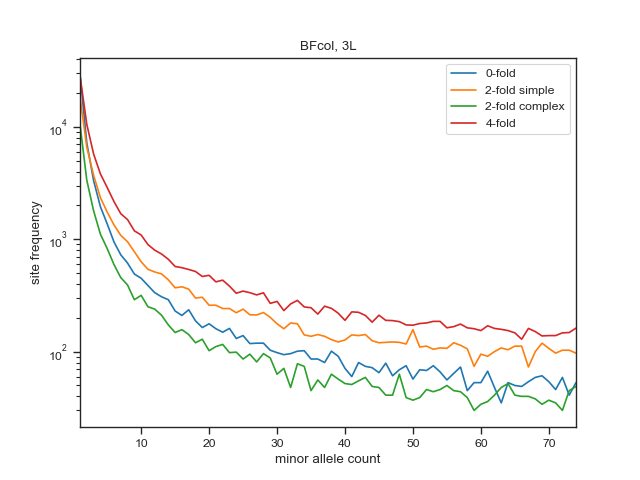

In [30]:
fig, ax = plt.subplots()

for deg, lbl in zip([DEG_0, DEG_2_SIMPLE, DEG_2_COMPLEX, DEG_4],
                    ['0-fold', '2-fold simple', '2-fold complex', '4-fold']):
    loc = df['CODON_DEG'] == deg
    sfs = allel.sfs_folded(ac[loc])
    allel.plot_sfs_folded(sfs, ax=ax, label=lbl)

ax.set_title('BFcol, 3L')
ax.legend()

In [31]:
!zip --help

Copyright (c) 1990-2008 Info-ZIP - Type 'zip "-L"' for software license.
Zip 3.0 (July 5th 2008). Usage:
zip [-options] [-b path] [-t mmddyyyy] [-n suffixes] [zipfile list] [-xi list]
  The default action is to add or replace zipfile entries from list, which
  can include the special name - to compress standard input.
  If zipfile and list are omitted, zip compresses stdin to stdout.
  -f   freshen: only changed files  -u   update: only changed or new files
  -d   delete entries in zipfile    -m   move into zipfile (delete OS files)
  -r   recurse into directories     -j   junk (don't record) directory names
  -0   store only                   -l   convert LF to CR LF (-ll CR LF to LF)
  -1   compress faster              -9   compress better
  -q   quiet operation              -v   verbose operation/print version info
  -c   add one-line comments        -z   add zipfile comment
  -@   read names from stdin        -o   make zipfile as old as latest entry
  -x   exclude the following nam

In [32]:
%%bash
cd '/home/joshjrey/Documents/mosquito_project/outputs/build_blocks'
rm -vf data.zip
zip data.zip *.csv

  adding: BFcol.3L.csv (deflated 80%)
  adding: BFgam.3L.csv (deflated 81%)
  adding: KE.3L.csv (deflated 78%)


In [33]:
!ls -lh {output_dir}

total 76M
-rw-r--r-- 1 joshjrey joshjrey 6.9M May 21 11:33 BFcol.3L.csv
-rw-r--r-- 1 joshjrey joshjrey 8.1M May 21 11:33 BFgam.3L.csv
-rw-r--r-- 1 joshjrey joshjrey  11M May  3 16:45 codon_degeneracy.zarr.zip
-rw-r--r-- 1 joshjrey joshjrey 9.9M May  3 16:45 codon_nonsyn.zarr.zip
-rw-r--r-- 1 joshjrey joshjrey 1.8M May  3 16:45 codon_position.zarr.zip
-rw-r--r-- 1 joshjrey joshjrey 3.3M May 21 11:39 data.zip
-rw-r--r-- 1 joshjrey joshjrey 1.5M May 21 11:33 KE.3L.csv
-rw-r--r-- 1 joshjrey joshjrey 1.8M May  7 15:42 seq_cls.zarr.zip
-rw-r--r-- 1 joshjrey joshjrey 5.4M May  7 15:44 seq_flen.zarr.zip
-rw-r--r-- 1 joshjrey joshjrey  12M May  7 15:44 seq_relpos_start.zarr.zip
-rw-r--r-- 1 joshjrey joshjrey  12M May  7 15:44 seq_relpos_stop.zarr.zip
-rw-r--r-- 1 joshjrey joshjrey 2.3M May  3 16:12 tbl_features.pkl.gz
-rw-r--r-- 1 joshjrey joshjrey 2.2M May  3 16:12 tbl_features.txt.gz
